In [1]:
import numpy as np
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph

import graph3d

%matplotlib inline

In [2]:
sns.set_palette('husl')

# Review of the Fourier Transform

In the traditional Euclidean domain, we can find the frequency-domain
representation of a time series signal using the Fourier transform:

#### Classical Fourier Transform
  \begin{equation}
    \hat{f}(\xi) = \int_{-\infty}^{\infty} f(t) e^{-2 \pi j \xi t} dt 
  \end{equation}

$\hat{f}$ is an expansion of $f$ in terms of complex exponentials, which are the
eigenfunctions of the Laplace operator:

#### Classical Fourier transform in terms of the Laplace operator
  \begin{equation}
    - \Delta (e^{2 \pi j \xi t}) = \frac{\partial^2}{\partial t^2} e^{2 \pi j \xi t} = 4 \pi^2 \xi^2 e^{2 \pi j \xi t} = k e^{2 \pi j \xi t}
  \end{equation}


In [3]:
# Define signal parameters
n = 500                # Number of data points
Fs = 500               # Maximum frequency
T = 1 / Fs             # Period
t = np.arange(0, n)*T  # Time range

# Create a signal by mixing sinwaves at different frequencies
freqs = [20, 60]
scales = [0.7, 1]
sinwaves = [scale*np.sin(2*np.pi*freq*t)
            for freq, scale in zip(freqs, scales)]
u_noise = np.random.randn(n)
f = sum(sinwaves) + u_noise

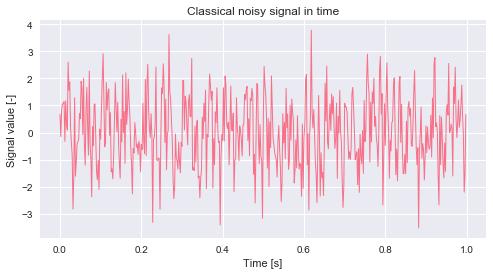

In [4]:
# Plot noisy signal
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, f, linewidth=1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal value [-]')
ax.set_title('Classical noisy signal in time')
plt.savefig('../img/graph_fourier_transform_0.pdf', bbox_inches='tight')

In [5]:
# Take the FFT of the signal
fhat = fftpack.fft(f)

# Get the frequency range
xi = np.linspace(0, Fs, n, endpoint=False)

# Get the magnitude of the FFT
mag = np.abs(fhat)

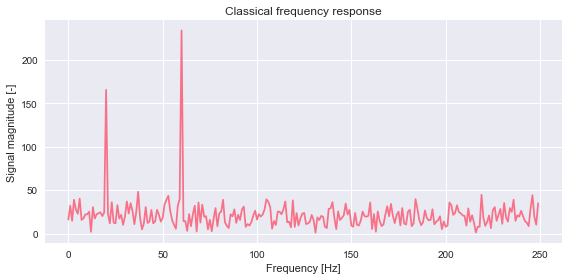

In [6]:
# Plot the magnitude of the frequency spectrum
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(xi[:(n // 2)], mag[:(n //2)])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Signal magnitude [-]')
ax.set_title('Classical frequency response')
plt.tight_layout()
plt.savefig('../img/graph_fourier_transform_1.pdf', bbox_inches='tight')

# The Graph Laplacian

For each vertex $i$, the Laplace operator computes the weighted sum of the
differences between the signal value at $i$ and the signal value at $i's$
neighbors ($j \in N_i$). 

#### The Laplacian is a difference operator
  \begin{equation}
    (\Delta f) (i) = (L f) (i) = \sum_{j \in N_i} W_{i, j} [f(i) - f(j)]
  \end{equation}

The Laplace operator for an undirected graph is simply the degree matrix minus the
adjacency matrix.

#### The Graph Laplacian
  \begin{equation}
    L = D - W
  \end{equation}

$L$ will have a full set of orthonormal eigenvectors, and real eigenvalues. Zero
will occur as an eigenvalue with multiplicity equal to the number of connected
components.


# Graph Fourier transform

The Graph Fourier transform is an expansion of $f$ in terms of the eigenvectors $u_l$ of the Graph Laplacian.
  
#### The Graph Fourier Transform

\begin{equation}
  \hat{f}(\lambda_l) = \sum_{i=1}^N f(i) u^*_l(i) 
\end{equation}

- Eigenvectors associated with the smallest eigenvalues vary slowly across the graph.
- Eigenvectors associated with the largest eigenvalues oscillate rapidly.

In the form of matrix functions:

\begin{equation}
  \hat{f} = U^* f
\end{equation}

\begin{equation}
  f = U \hat{f}
\end{equation}

# Fourier transform on a ring graph

In [7]:
# Create a "ring" adjacency matrix
n = 500
Aring = np.roll(np.eye(n), -1, axis=1) + np.roll(np.eye(n), 1, axis=1)

In [8]:
# Compute the laplacian of the adjacency matrix
Lring = csgraph.laplacian(Aring)

# Get the eigenvalues and eigenvectors of the laplacian
l, u = linalg.eigh(Lring)

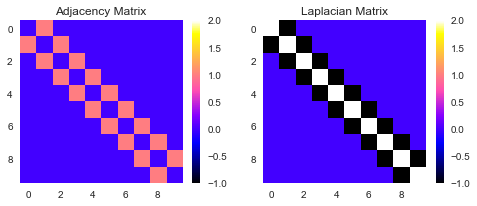

In [9]:
# Plot the adjacency matrix and laplacian
fig, ax = plt.subplots(1, 2, figsize=(8,3))

im0 = ax[0].imshow(Aring[:10,:10], cmap='gnuplot2', vmin=-1, vmax=2)
im1 = ax[1].imshow(Lring[:10,:10], cmap='gnuplot2', vmin=-1, vmax=2)
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
ax[0].grid('off')
ax[1].grid('off')

ax[0].set_title('Adjacency Matrix')
ax[1].set_title('Laplacian Matrix')
plt.savefig('../img/graph_fourier_transform_2.pdf', bbox_inches='tight')

In [10]:
# Compute the graph fourier transform of the graph signal
ghat = np.asarray([(f*u[:, w]).sum() for w in range(len(l))])

# Equivalent computation of the graph fourier transform
ghat = (np.conj(u).T @ f)

# Recompute the graph signal using the inverse graph fourier transform
g = u @ ghat

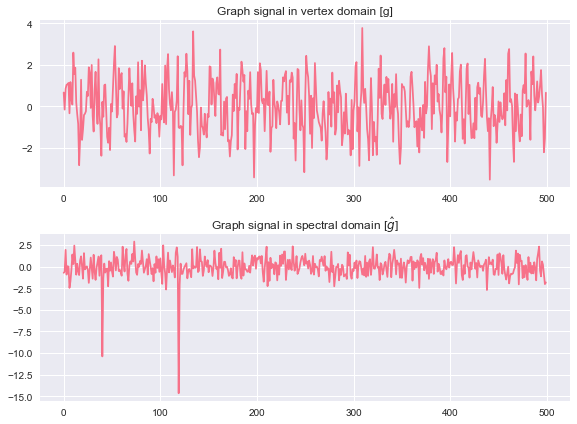

In [11]:
# Plot the graph signal in the vertex and spectral domains
fig, ax = plt.subplots(2, figsize=(8,6))

ax[0].plot(g)
ax[1].plot(ghat)

ax[0].set_title(r'Graph signal in vertex domain [g]')
ax[1].set_title(r'Graph signal in spectral domain [$\hat{g}$]')

plt.tight_layout()
plt.savefig('../img/graph_fourier_transform_3.pdf', bbox_inches='tight')

# Fourier transform on Minnesota road network

### Load data

In [12]:
minn = io.loadmat('../data/minnesota.mat')

In [13]:
Aroads = minn['Problem'][0][0][2]
xy = minn['Problem'][0][0][8][0][0][0]

### Isolate largest connected component

In [14]:
numcomp, components = sparse.csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

In [15]:
links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

### Plot road network

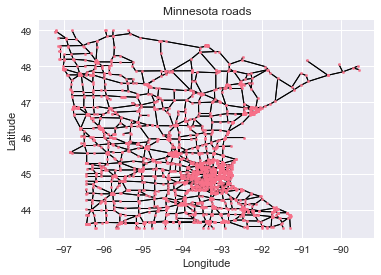

In [16]:
# Plot the road network
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.add_collection(lc)
ax.scatter(xy[:, 0], xy[:, 1], s=6, zorder=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Minnesota roads')
plt.savefig('../img/graph_fourier_transform_4.pdf', bbox_inches='tight')

# Eigendecomposition of the Laplacian carries frequency information

In [17]:
# Compute the graph laplacian and the eigendecomposition
Lroads = csgraph.laplacian(Aroads)
l, u = np.linalg.eigh(Lroads.todense())
u = np.asarray(u)

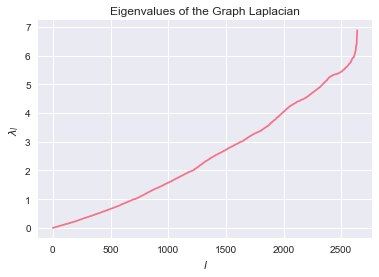

In [18]:
# Plot the frequency spectrum of the laplacian
fig, ax = plt.subplots()
ax.plot(l)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$\lambda_l$')
ax.set_title('Eigenvalues of the Graph Laplacian')
plt.savefig('../img/graph_fourier_transform_5.pdf', bbox_inches='tight')

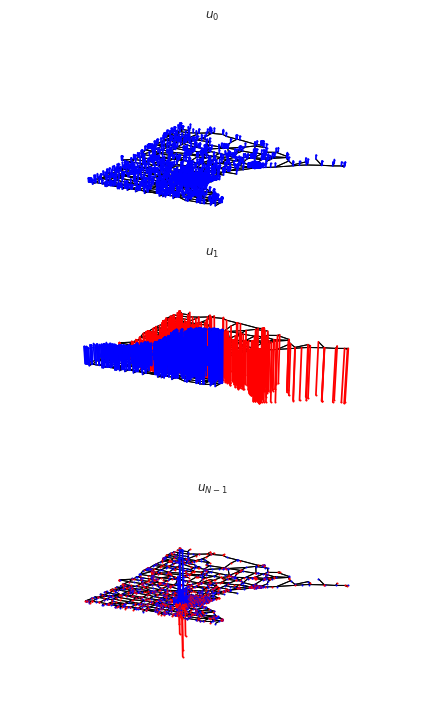

In [19]:
# Plot selected eigenvectors of the laplacian
fig = plt.figure(figsize=(6,10))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], u[:, 0], zmin=0, zmax=0.5, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$u_0$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], u[:, 1], fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$u_1$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], u[:, -1], fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$u_{N-1}$')

plt.tight_layout()
plt.savefig('../img/graph_fourier_transform_6.pdf', bbox_inches='tight')

# Kernels on graphs

## Heat kernel

In [20]:
# Define a heat kernel directly in the graph spectral domain
ghat = np.exp(-5*l)

# Use the inverse graph fourier transform to convert the kernel to a graph signal
g = sum([ghat[i] * u[:, i] for i in range(len(l))])
g = u @ ghat

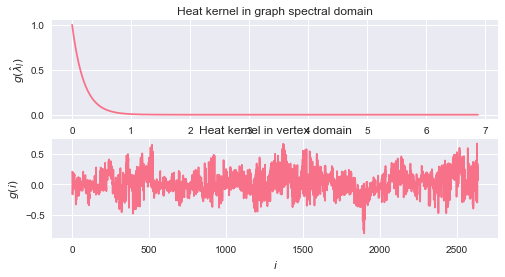

In [21]:
# Plot the heat kernel in the spectral and vertex domains
fig, ax = plt.subplots(2, figsize=(8, 4))

ax[0].set_title('Heat kernel in graph spectral domain')
ax[0].plot(l, ghat)
ax[0].set_xlabel(r'$\lambda_l$')
ax[0].set_ylabel(r'$\hat{g(\lambda_l)}$')

ax[1].set_title('Heat kernel in vertex domain')
ax[1].plot(np.arange(len(g)), g)
ax[1].set_xlabel(r'$i$')
ax[1].set_ylabel(r'$g(i)$')
plt.savefig('../img/graph_fourier_transform_7.pdf', bbox_inches='tight')

## Putting the heat kernel in the vertex domain

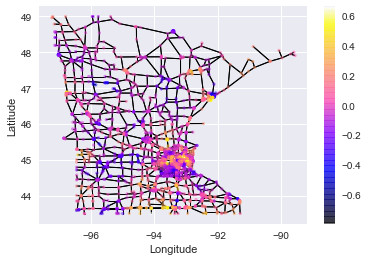

In [22]:
# Plot the graph signal corresponding to the heat kernel
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[:, 0], xy[:, 1], s=8, c=g, alpha=0.5,
                zorder=2, cmap='gnuplot2', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('../img/graph_fourier_transform_8.pdf', bbox_inches='tight')

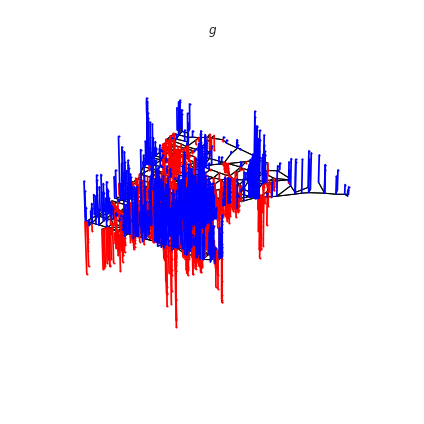

In [23]:
# Plot the graph signal corresponding to the heat kernel
fig = plt.figure(figsize=(6,6))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], g, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')
plt.savefig('../img/graph_fourier_transform_9.pdf', bbox_inches='tight')